# Financial Market Analysis using Recurrent Neural Network

* Ref: Fabrice Daniel, Financial Time Series Data Processing for Machine Learning, arXiv:1907.03010
* Financial data clearly has trends, meaning that it is not a stationary time series. To test for stationarity two criterions are Augmented Dickey-Fuller test (ADF) and pvalue. 
* Some methods to make it staionary is differencing using df['Open'].diff().fillna(0.0), or to compute the daily return which is df['DailyReturn'] = df['Close'] - df['Open']. 
* Note that differencing is identical to return if nobody trades after market. 
* To train a time series data, typically one creates time windows as inputs, for instance a time window of 20 consecutive days. (This is the "look back period" for forecasting)
* Specially, build a training set S consisting of series $\hat{X}=\{X_0,X_1,\dots,X_{K-1}\}$, where $X_t=\{x_{t-n},\dots,x_{t-1}\}$, and prediction as $\hat{Y}=\{y_0,y_1,\dots,y_{K-1}\}$ where $y_t=\{x_{t}\}$.
* Note that this is a overlapping window of time series. As a result, the train/validation/test set split must also be chronological.
* Identify training objectives. This could be many. The simplest is the mean square error metric, which measures how close is the predicted price to the actual price. 
* Next we can look at various classifiers, such as the closing price at t is greater than the closing price at t-5 (i.e., predict a five day trend.). This converts the regression model to a classification problem. 
* Next we look at multi-day forecasting. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [1]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
df = GetInformation.history(period="max")
# print(df.head(4))
# df.plot(y=['Open','Close'])
# plt.show()

# Create time windows of size n_window, and multiday forecasting n_forecast 

In [3]:
def create_time_windows(df, n_window ,n_forecast, scale=True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y, scaler = [], [], []
    for i in range(n_window,N-n_forecast):
        tmp = df.iloc[(i-n_window):(i+n_forecast)].to_numpy()
        if scale:
            sc = MinMaxScaler(feature_range=(0,1))
            tmp = sc.fit_transform(tmp)
            scaler.append(sc)
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y), scaler

df1 = pd.DataFrame({'Open':df['Open']})

In [4]:
def plot_regression_results(X,y,model=0,mode='test'):
  fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True,sharey=True)
  for r in range(4):
    for c in range(4):
        idx = np.random.randint(X.shape[0])
        ax[r,c].plot(range(X.shape[1]),X[idx,:,0],"b-",label='train')
        ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),y[idx,:,0],"r-^",label='actual',ms=3)
        if model != 0:
            val = model(X[idx:(idx+1),:,:1])
            ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),val[0],"g-x",label='pred.',ms=3)
        if r ==0 and c ==0:
          ax[r,c].legend(fontsize=9)
  fig.suptitle(mode)
  plt.tight_layout()
  plt.show()
  plt.close()

# LSTM with Quantile loss
- 20 days data and predict 1 day using quantile loss 

In [13]:
n_window, n_forecast = 20, 1   # 20 days predict 1 day
X, y, scaler = create_time_windows(df1, n_window = n_window, n_forecast = n_forecast)
Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

# Quantile loss: 
def quantile_loss(q, y, y_p):
    e = y-y_p
    return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

In [14]:
nfeatures = 1 # only use first nfeature columns for training and prediction
ntrain = int(Xtrain.shape[0]*0.8)
Xtt, ytt = Xtrain[:ntrain,:,:nfeatures], ytrain[:ntrain,:,0]
Xval, yval = Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]

quantiles = [0.05,0.5,0.95]
models = []
histories = []
for q in quantiles:
    print(f"Quantile {q} model:")
    model= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                            keras.layers.LSTM(32,return_sequences=True),
                            keras.layers.Dropout(0.2),
                            keras.layers.LSTM(32,return_sequences=False),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1)])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=lambda y, y_p: quantile_loss(q,y,y_p))
    history = model.fit(Xtt,ytt, batch_size= 32, verbose = 0, epochs = 50,validation_data=(Xval,yval))
    models.append(model)
    histories.append(history)

Quantile 0.05 model:
Quantile 0.5 model:
Quantile 0.95 model:


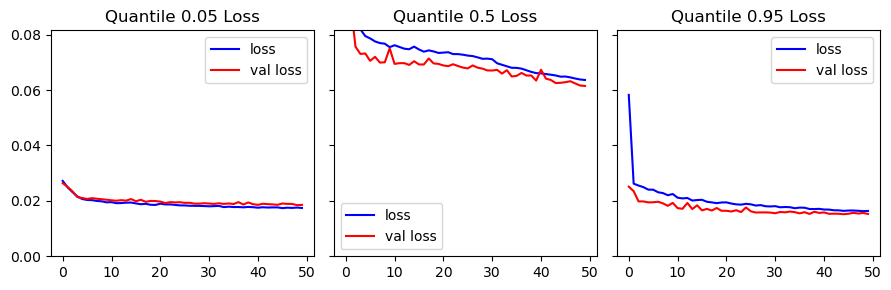

In [17]:
fig, ax = plt.subplots(1,len(histories),figsize=(3*len(histories),3),sharex=True,sharey=True)
for i in range(len(histories)):
    history = histories[i]
    ax[i].plot(history.history['loss'],'b-',label='loss')
    ax[i].plot(history.history['val_loss'],'r-',label='val loss')
    ax[i].set_ylim([0,1.4*max(history.history['loss'])])
    ax[i].legend()
    ax[i].set_title(f'Quantile {quantiles[i]} Loss')
plt.tight_layout()
plt.show()
plt.close(fig)

# Forecasting based on quantile regressors

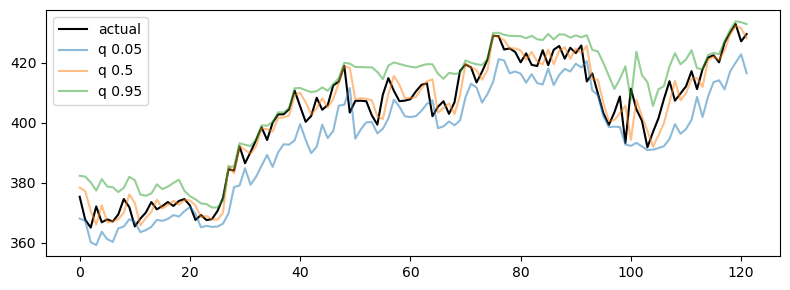

In [29]:
# plot predictions based on model 2
def plot_forecast(X,y,sc,models,quantiles):
    fig,ax = plt.subplots(figsize=(8,3))
    yactual = y.copy()
    # revert to original form
    for i in range(yactual.shape[0]):
        yactual[i,:,:] = sc[i].inverse_transform(yactual[i,:,:])
    ax.plot(yactual[:,0,0],"k-",label="actual")

    for i in range(len(quantiles)):
        q = quantiles[i]
        ypred = models[i](X[:,:,:1]).numpy().reshape(-1,1,1)
        for i in range(ypred.shape[0]):
            ypred[i,:,:] = sc[i].inverse_transform(ypred[i,:,:])

        ax.plot(ypred[:,0,0],"-",label=f"q {q}",alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)

scaler_test = scaler[Xtrain.shape[0]:]
begin_idx = 1800
plot_forecast(Xtest[begin_idx:,...],ytest[begin_idx:,...],scaler_test[begin_idx:],models,quantiles)